# Scope of this project

The objective of this project was to compare the number of homicides by firearms in the US with rates seen in other countries while incorporating other factors like gun ownership, GDP, and population. In summary, the data confirms what many Americans know anecdotally or through media coverage: that the US is an outlier both in terms of the number of people who own guns and the number of people who are victims of gun violence.

## Setup

In [1]:
# Import libraries
import os
import sys
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import urllib.request
from urllib.request import urlopen as urlopen
import seaborn as sns

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Setup environmental variable
os.environ["PUIdata"] = "{}/PUIdata".format(os.getenv("HOME"))

## Data gathering and cleanup

In [3]:
# Download gun violence data
!curl -O https://serv.cusp.nyu.edu/~fbianco/PUIdata/WorldFirearmsMurdersAndOwnership.csv
!mv WorldFirearmsMurdersAndOwnership.csv $PUIdata

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7852  100  7852    0     0  17586      0 --:--:-- --:--:-- --:--:-- 17605


In [4]:
# Pull in firearms, population, and gdp data
firearm = pd.read_csv(os.getenv("PUIdata") + '/WorldFirearmsMurdersAndOwnership.csv')
pop = pd.read_excel('http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=excel', skiprows=3)
gdp = pd.read_excel('http://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel', skiprows=3)

In [5]:
# Pull in mass shooting data
url = 'data:application/octet-stream;charset=utf-8,Country%2CGuns%20per%20100%20inhabitants%2CNumber%20of%20mass%20shootings%20(1983-2013)%0AAustralia%2C15%2C4%0AAustria%2C30.4%2C1%0ABelgium%2C17.2%2C2%0ACanada%2C30.8%2C4%0ADenmark%2C12%2C0%0AFinland%2C45.3%2C2%0AFrance%2C31.2%2C6%0AGermany%2C30.3%2C7%0AGreece%2C22.5%2C0%0AHolland%2C3.9%2C2%0AHungary%2C5.5%2C0%0AIceland%2C30.3%2C0%0AIreland%2C8.6%2C0%0AItaly%2C11.9%2C0%0AJapan%2C0.6%2C0%0ALuxembourg%2C15.3%2C0%0ANew%20Zealand%2C22.6%2C3%0ANorway%2C31.3%2C1%0APoland%2C1.3%2C0%0APortugal%2C8.5%2C1%0ASpain%2C10.4%2C1%0ASweden%2C31.6%2C2%0ASwitzerland%2C45.7%2C2%0AUnited%20Kingdom%2C6.2%2C3%0AUnited%20States%2C88.8%2C78'
filename = 'data-pvLFI.csv'

urllib.request.urlretrieve(url, filename)
os.system("mv " + filename + " " + os.getenv("PUIdata"))

string = os.getenv("PUIdata") + '/' + filename
mass_shooting = pd.read_csv(string)

In [6]:
firearm.head(5)

,Country/Territory,ISO code,Source,% of homicides by firearm,Number of homicides by firearm,"Homicide by firearm rate per 100,000 pop",Rank by rate of ownership,Average firearms per 100 people,Average total all civilian firearms
0,Albania,AL,CTS,65.9,56.0,1.76,70.0,8.6,270000.0
1,Algeria,DZ,CTS,4.8,20.0,0.06,78.0,7.6,1900000.0
2,Angola,AO,NaN,NaN,NaN,NaN,34.0,17.3,2800000.0
3,Anguilla,AI,WHO-MDB,24.0,1.0,7.14,NaN,NaN,NaN
4,Argentina,AR,Ministry of Justice,52.0,1198.0,3.02,62.0,10.2,3950000.0


In [7]:
mass_shooting.head(5)

,Country,Guns per 100 inhabitants,Number of mass shootings (1983-2013)
0,Australia,15.0,4
1,Austria,30.4,1
2,Belgium,17.2,2
3,Canada,30.8,4
4,Denmark,12.0,0


In [8]:
pop.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0,NaN


In [9]:
gdp.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.498883e+09,2.390503e+09,2.549721e+09,2.534637e+09,2.581564e+09,2.649721e+09,2.691620e+09,2.646927e+09,2.700559e+09,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.243909e+10,1.585657e+10,1.780429e+10,1.990732e+10,2.056107e+10,2.048489e+10,1.990711e+10,1.904636e+10,1.954398e+10,NaN
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,7.030716e+10,8.379950e+10,1.117897e+11,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,NaN
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.204421e+10,1.192696e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322825e+10,1.138693e+10,1.188368e+10,1.303854e+10,NaN
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09,NaN


### Merge data

In [10]:
# Rename columns to prep for merge
firearm.rename(columns={'Country/Territory':'Country'}, inplace=True)
pop.rename(columns={'Country Name':'Country'}, inplace=True)
gdp.rename(columns={'Country Name':'Country'}, inplace=True)

In [11]:
merged = mass_shooting.merge(firearm, how='inner', on='Country')

In [12]:
merged = merged.merge(pop, how='inner', on='Country')

In [13]:
merged = merged.merge(gdp, how='inner', on='Country')

In [14]:
merged.head(5)

,Country,Guns per 100 inhabitants,Number of mass shootings (1983-2013),ISO code,Source,% of homicides by firearm,Number of homicides by firearm,"Homicide by firearm rate per 100,000 pop",Rank by rate of ownership,Average firearms per 100 people,...,2009_y,2010_y,2011_y,2012_y,2013_y,2014_y,2015_y,2016_y,2017_y,2018_y
0,Australia,15.0,4,AU,NSO,11.5,30.0,0.14,42.0,15.0,...,9.264482e+11,1.144261e+12,1.394281e+12,1.543411e+12,1.573697e+12,1.464955e+12,1.349034e+12,1.208039e+12,1.323421e+12,NaN
1,Austria,30.4,1,AT,CTS,29.5,18.0,0.22,14.0,30.4,...,4.001723e+11,3.918927e+11,4.311203e+11,4.094252e+11,4.300687e+11,4.418854e+11,3.820659e+11,3.908000e+11,4.165957e+11,NaN
2,Belgium,17.2,2,BE,WHO-MDB,39.5,70.0,0.68,34.0,17.2,...,4.845528e+11,4.835480e+11,5.270085e+11,4.978842e+11,5.209255e+11,5.307710e+11,4.550396e+11,4.675455e+11,4.926813e+11,NaN
3,Canada,30.8,4,CA,CTS,32.0,173.0,0.51,13.0,30.8,...,1.371153e+12,1.613464e+12,1.788648e+12,1.824289e+12,1.842628e+12,1.799269e+12,1.559623e+12,1.535768e+12,1.653043e+12,NaN
4,Denmark,12.0,0,DK,CTS,31.9,15.0,0.27,54.0,12.0,...,3.212414e+11,3.219954e+11,3.440032e+11,3.271489e+11,3.435844e+11,3.529936e+11,3.012985e+11,3.068997e+11,3.248720e+11,NaN


In [15]:
# Claen up dataframe
df_keep_cols = ['Country','Average total all civilian firearms','2012_x','2012_y','Number of homicides by firearm',\
               'Guns per 100 inhabitants','Number of mass shootings (1983-2013)']
df_del_cols = []
df_cols = merged.columns.get_values()
for col in df_cols:
    if col not in df_keep_cols:
        df_del_cols.append(col)
merged.drop(df_del_cols, axis=1, inplace=True)

In [16]:
# Rename columns
merged.rename(columns={'Guns per 100 inhabitants':'guns_per_100','Number of mass shootings (1983-2013)':\
                      'mass_shtings_83_13', 'Number of homicides by firearm':'fire_hom', \
                       'Average total all civilian firearms':'avg_fire', '2012_x':'2012_pop',\
                      '2012_y':'2012_gdp'}, inplace=True)

In [17]:
merged.head(5)

,Country,guns_per_100,mass_shtings_83_13,fire_hom,avg_fire,2012_pop,2012_gdp
0,Australia,15.0,4,30.0,3050000.0,22742475.0,1.543411e+12
1,Austria,30.4,1,18.0,2500000.0,8429991.0,4.094252e+11
2,Belgium,17.2,2,70.0,1800000.0,11128246.0,4.978842e+11
3,Canada,30.8,4,173.0,9950000.0,34750545.0,1.824289e+12
4,Denmark,12.0,0,15.0,650000.0,5591572.0,3.271489e+11


## Data Exploration and Plotting

### Plot mass shooting against GDP

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


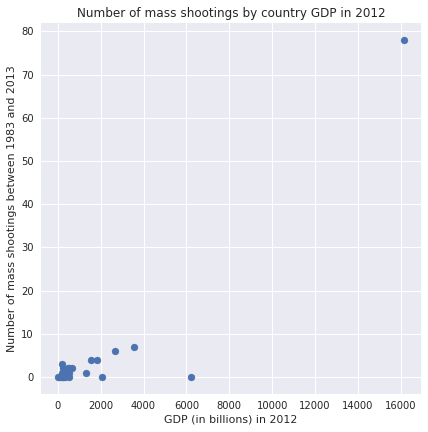

In [18]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221)
ax.scatter(merged['2012_gdp']/1e9, merged['mass_shtings_83_13'])
ax.set_xlabel("GDP (in billions) in 2012")
ax.set_ylabel("Number of mass shootings between 1983 and 2013")
ax.set_title("Number of mass shootings by country GDP in 2012")

plt.show()

### Notes on above plot

The above plots show the number of mass shootings between 1983 and 2013 in terms of total GDP in billions and in terms of GDP per person. There's an outlier that I hone in on in the following plots.

### Plot of the average number of civilian firearms per person

In [19]:
fire = merged['avg_fire'].tolist()
countries = merged['Country'].tolist()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


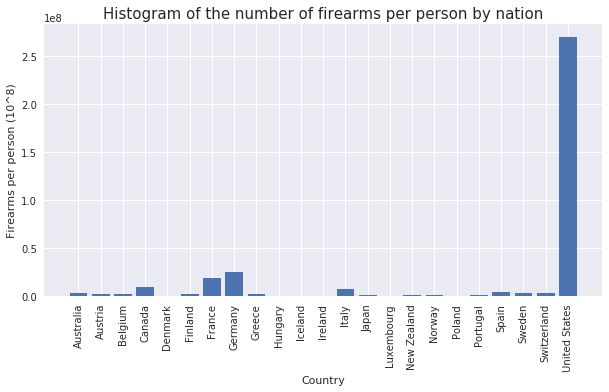

In [20]:
fig = plt.figure(figsize=(10,5)) 
plt.bar(countries, fire)
plt.xticks(rotation='vertical')
plt.xlabel('Country')
plt.ylabel('Firearms per person (10^8)')
plt.title('Histogram of the number of firearms per person by nation', fontsize=15)
plt.show()

### Note on the above plot

Here we can see that the US has by far the most firearms per person.

### Plot of the average number of homicides by firearms per person

The following is a histogram of the 23 countries in the data set.

In [21]:
merged['hom_pp'] = merged["fire_hom"] / merged['2012_pop'] * 1e3

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


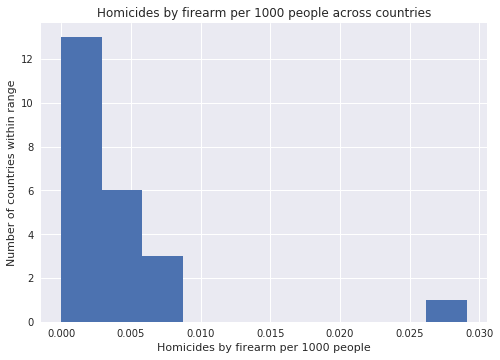

In [22]:
fig, ax = plt.subplots()
ax.hist(merged['hom_pp'])
ax.set_xlabel('Homicides by firearm per 1000 people')
ax.set_ylabel('Number of countries within range')
ax.set_title("Homicides by firearm per 1000 people across countries")
plt.show()

### Note on above plot

Again, we see an outlier where there's only one nation with more than .01 firearm homicides per 1000 people.

### Plot of the number of homicides by firearm against the number of civilian firearms

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


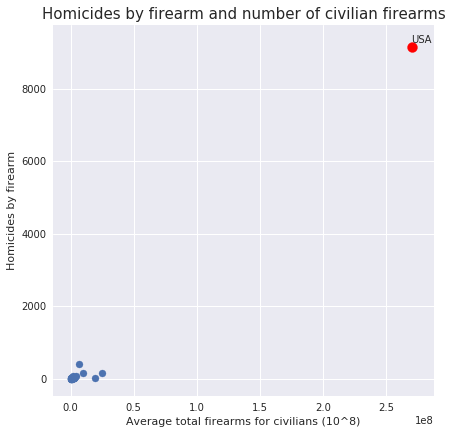

In [23]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
scatter = ax1.scatter(merged['avg_fire'], merged['fire_hom'])
ax1.set_xlabel("Average total firearms for civilians (10^8)")
ax1.set_ylabel("Homicides by firearm")
ax1.set_title("Homicides by firearm and number of civilian firearms", fontsize=15)
usax = merged.loc[merged['Country'] == 'United States', 'avg_fire'].iloc[0]
usay = merged.loc[merged['Country'] == 'United States', 'fire_hom'].iloc[0]
ax1.annotate('USA',xy=(usax,usay),xytext=(usax,usay+100), fontsize=10)
ax1.scatter(usax, usay, color='r', alpha=1, s=100)

plt.show()

### Notes on above plots

In the plots for total firearm homicides by the total number of firearms per person, we see most countries with similar values but the US is, again, an outlier. We see that for most countries, they have a relatively low number of total average firearms for civilians and similarly low numbers of homicides by firearm. The US, however, has high numbers of firearm homicides and total firearms.

### Plot of the number of mass shootings against the number of civilian firearms

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


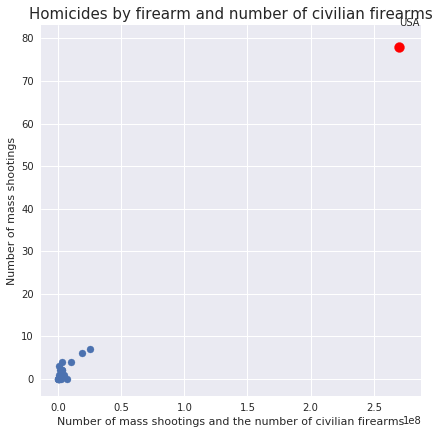

In [24]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(221)
scatter = ax1.scatter(merged['avg_fire'], merged['mass_shtings_83_13'])
ax1.set_xlabel("Number of mass shootings and the number of civilian firearms")
ax1.set_ylabel("Number of mass shootings")
ax1.set_title("Homicides by firearm and number of civilian firearms", fontsize=15)
usax = merged.loc[merged['Country'] == 'United States', 'avg_fire'].iloc[0]
usay = merged.loc[merged['Country'] == 'United States', 'mass_shtings_83_13'].iloc[0]
ax1.annotate('USA',xy=(usax,usay),xytext=(usax,usay+5), fontsize=10)
ax1.scatter(usax, usay, color='r', alpha=1, s=100)

plt.show()

### Note on above plots

Again, we see the US as the outlier both in terms of the number of mass shootings and in terms of the number of civilian firearms.

## Modeling

### Linear regression plotting mass shootings per person as a function of civilian firearms per person

In [25]:
merged['mass_shtings_83_13_pp'] = merged['mass_shtings_83_13']/merged['2012_pop']
merged['firearms_pp'] = merged['avg_fire']/merged['2012_pop']

In [26]:
merged['mass_shtings_83_13_pp_scaled'] = merged['mass_shtings_83_13_pp']*1e7

In [27]:
x = merged['firearms_pp'].tolist()
y = merged['mass_shtings_83_13_pp_scaled'].tolist()

In [28]:
newx = sm.add_constant(x)

In [29]:
ols_fit = smf.OLS(y, newx).fit()

In [30]:
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     4.981
Date:                Thu, 14 Feb 2019   Prob (F-statistic):             0.0367
Time:                        16:18:36   Log-Likelihood:                -40.676
No. Observations:                  23   AIC:                             85.35
Df Residuals:                      21   BIC:                             87.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3684      0.497      0.742      0.467        -0.665     1.402
x1             3.8373      1.719      2.232      0.037         0.262     7.413
==============================================================================
Omnibus:                       34.558   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.760
Skew:                           2.666   Prob(JB):                     5.32e-20
Kurtosis:                      11.012   Cond. No.                         5.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
x.sort()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


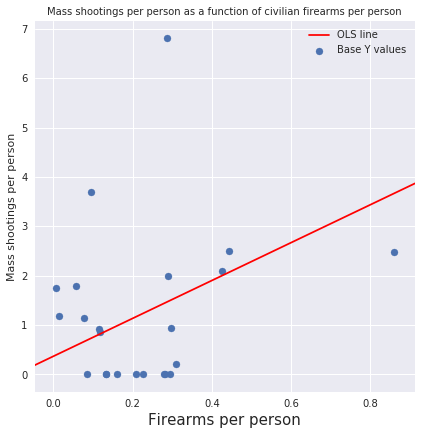

In [32]:
fig = plt.figure(figsize=(15, 15))

ax2 = fig.add_subplot(221)
ax2.scatter(x, y, label='Base Y values')
abline_plot(model_results=ols_fit, ax=ax2, color='red', label='OLS line')
ax2.set_xlabel('Firearms per person', fontsize=15)
ax2.set_ylabel("Mass shootings per person")
ax2.set_title("Mass shootings per person as a function of civilian firearms per person", fontsize=10)
ax2.legend()

plt.legend()
plt.show()

### Notes on above plot

The above plot shows a linear regression for mass shootings per person as a function of the number of firearms per person. Overall, the plot show that there is a positive correlation between the number of firearms per person and the number of mass shootings per person.